In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Importing the data

In [2]:
s_wd = "C:/Users/sonis/Capstone/PivotedClass/"

In [3]:
# Path to the specific CSV file
csv_path = s_wd + "df_filtered24_pivot.csv"

# Read the CSV file using Dask
df24 = dd.read_csv(csv_path)

# Check the first few rows
print(df24.head())

   ANON_ID     HH_00     HH_01     HH_02     HH_03     HH_04     HH_05  \
0        3  0.210294  0.193382  0.180147  0.182941  0.172206  0.181324   
1        5  0.070413  0.079973  0.086373  0.084747  0.077867  0.070707   
2        6  0.045344  0.045581  0.050742  0.047781  0.053031  0.052594   
3        7  0.107103  0.107570  0.105888  0.107757  0.109720  0.104766   
4        8  0.130417  0.130521  0.130000  0.126042  0.125729  0.128438   

      HH_06     HH_07     HH_08  ...     HH_38     HH_39     HH_40     HH_41  \
0  0.177463  0.197463  0.199552  ...  0.293731  0.285821  0.273881  0.266119   
1  0.084573  0.085653  0.079613  ...  0.185026  0.177434  0.212658  0.280697   
2  0.046406  0.051500  0.048563  ...  0.097344  0.105219  0.098375  0.070500   
3  0.116355  0.105701  0.094953  ...  0.483738  0.247477  0.221682  0.211028   
4  0.123263  0.125263  0.131789  ...  0.380206  0.284583  0.300619  0.263053   

      HH_42     HH_43     HH_44     HH_45     HH_46     HH_47  
0  0.24522

# SVD

In [4]:
missing_per_column = df24.isna().sum().compute()  # Compute actual values
total_missing = missing_per_column.sum()  # Compute total missing values

# Compute total rows and columns
total_rows, total_columns = df24.shape
total_rows = total_rows.compute()  # Get actual row count

# Print summary
print(f"Total missing values: {total_missing}")
print(f"Total rows: {total_rows}, Total columns: {total_columns}")

Total missing values: 346
Total rows: 5641, Total columns: 49


In [5]:
# Convert Dask DataFrame to Pandas (if needed for scikit-learn)
df24 = df24.compute()  # Converts to Pandas DataFrame

# Drop 'ANON_ID' since it's just an identifier
X = df24.drop(columns=['ANON_ID'])

In [6]:
# Handle missing values by replacing with the mean of each column
X = X.fillna(X.mean())

# Standardize the data: it's important for SVD to work well when the features are on different scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Explained variance ratio: [0.61986973 0.08402566 0.05493383 0.04455589 0.02688013 0.0212523
 0.01902686 0.01504797 0.01279169 0.0113969 ]


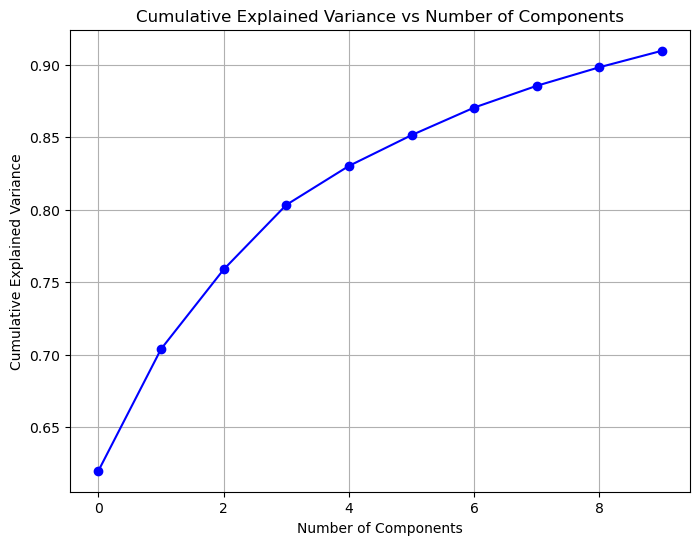

In [22]:
# Apply Truncated SVD (choose the number of components to retain)
n_components = 10 
svd = TruncatedSVD(n_components=n_components)

# Perform the SVD
X_svd = svd.fit_transform(X_scaled)

# Explained variance ratio (percentage of variance explained by each component)
print(f"Explained variance ratio: {svd.explained_variance_ratio_}")

# Cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

The first component explains about 62% of the variance. The second component explains 8.40%, and the third explains 5.5% and so on.

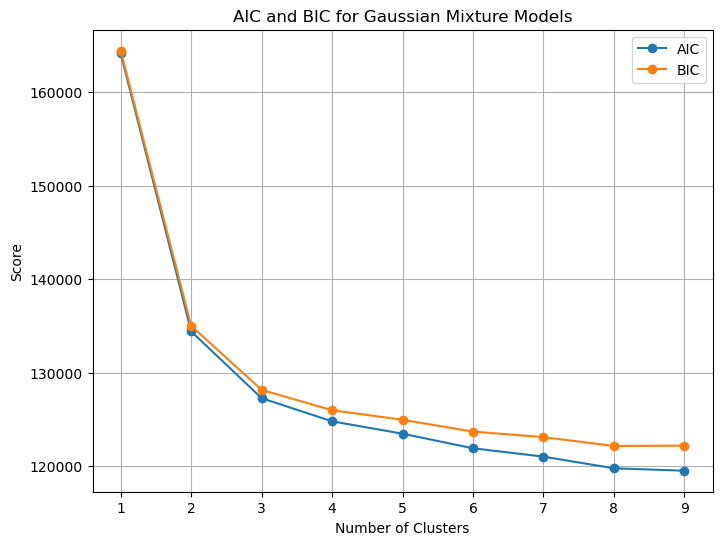

In [26]:
# First 2 principal components
X_reduced = X_svd[:, :8]  

# Fit GMM with different number of clusters and compute AIC/BIC
n_clusters_range = range(1, 10)
aic_scores = []
bic_scores = []

for n in n_clusters_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_reduced)
    aic_scores.append(gmm.aic(X_reduced))
    bic_scores.append(gmm.bic(X_reduced))

# Plot AIC and BIC scores
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, aic_scores, label='AIC', marker='o')
plt.plot(n_clusters_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('AIC and BIC for Gaussian Mixture Models')
plt.legend()
plt.grid()
plt.show()

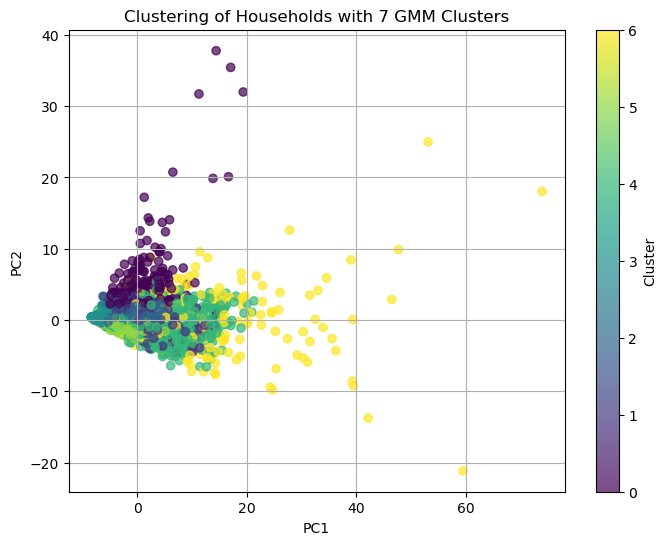

In [24]:
# Fit GMM with the optimal number of clusters (3 or 4)
optimal_clusters = 7
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(X_reduced)

# Predict cluster labels
labels = gmm.predict(X_reduced)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clustering of Households with {optimal_clusters} GMM Clusters")
plt.grid(True)
plt.show()

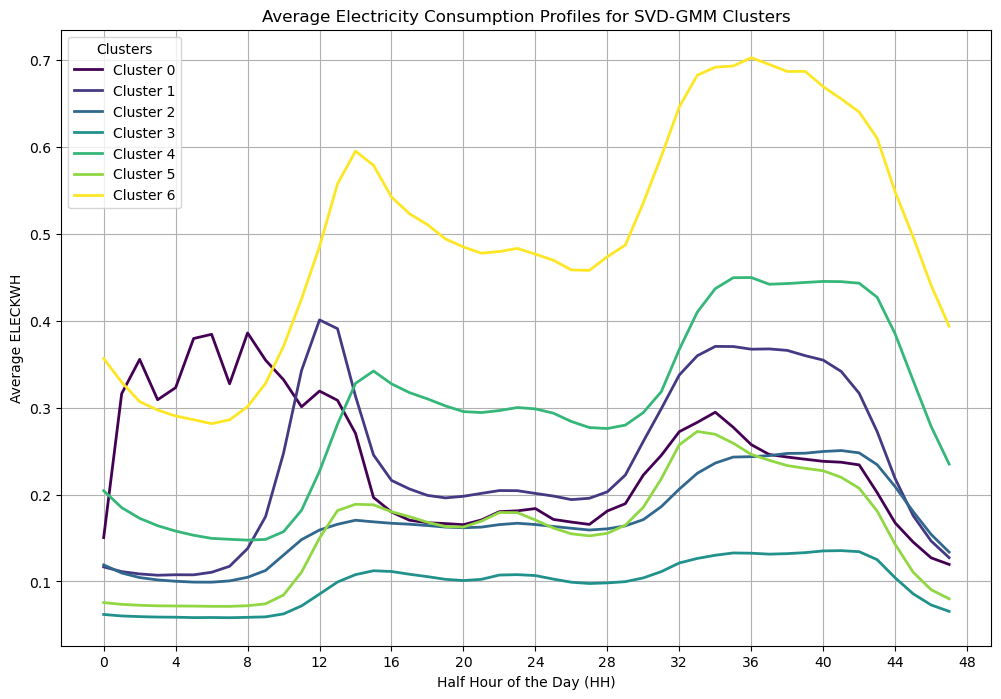

In [25]:
# Merge cluster labels back with electricity consumption data
df_clustered = df24.copy()
df_clustered["Cluster"] = labels

# Convert to long format
df_long = df_clustered.melt(id_vars=["ANON_ID", "Cluster"], var_name="HH", value_name="ELECKWH")
df_long["HH"] = df_long["HH"].str.extract(r'(\d+)').astype(int)  # Extract HH as integer

# Compute average consumption per HH for each cluster
cluster_avg_consumption = df_long.groupby(['Cluster', 'HH'])['ELECKWH'].mean().reset_index()

# Plot cluster average profiles
plt.figure(figsize=(12, 8))
num_clusters = df_long["Cluster"].nunique()
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

for i, cluster_id in enumerate(cluster_avg_consumption["Cluster"].unique()):
    cluster_data = cluster_avg_consumption[cluster_avg_consumption["Cluster"] == cluster_id]
    plt.plot(cluster_data["HH"], cluster_data["ELECKWH"], 
             label=f'Cluster {cluster_id}', color=colors[i], linewidth=2)

plt.title('Average Electricity Consumption Profiles for SVD-GMM Clusters')
plt.xlabel('Half Hour of the Day (HH)')
plt.ylabel('Average ELECKWH')
plt.xticks(range(0, 49, 4))
plt.legend(title="Clusters")
plt.grid(True)
plt.show()

Number of Clusters: 2, Silhouette Score: 0.2748638623846966
Number of Clusters: 3, Silhouette Score: 0.09653708818002972
Number of Clusters: 4, Silhouette Score: 0.15648505745157418
Number of Clusters: 5, Silhouette Score: 0.06646336191919631
Number of Clusters: 6, Silhouette Score: 0.02526449126245233
Number of Clusters: 7, Silhouette Score: -0.04162607706958763
Number of Clusters: 8, Silhouette Score: -0.004408572512207164
Number of Clusters: 9, Silhouette Score: -0.036938315371257004
Number of Clusters: 10, Silhouette Score: -0.042973471057598175
Number of Clusters: 11, Silhouette Score: -0.041423307477917386
Number of Clusters: 12, Silhouette Score: -0.058758200826389606
Number of Clusters: 13, Silhouette Score: -0.052866160228532376
Number of Clusters: 14, Silhouette Score: -0.0714724822934971
Number of Clusters: 15, Silhouette Score: -0.06983731862884879
Number of Clusters: 16, Silhouette Score: -0.07169540700230369
Number of Clusters: 17, Silhouette Score: -0.07816441964485309
N

,Number of Clusters,Silhouette Score
0,2,0.274864
1,3,0.096537
2,4,0.156485
3,5,0.066463
4,6,0.025264
5,7,-0.041626
6,8,-0.004409
7,9,-0.036938
8,10,-0.042973
9,11,-0.041423


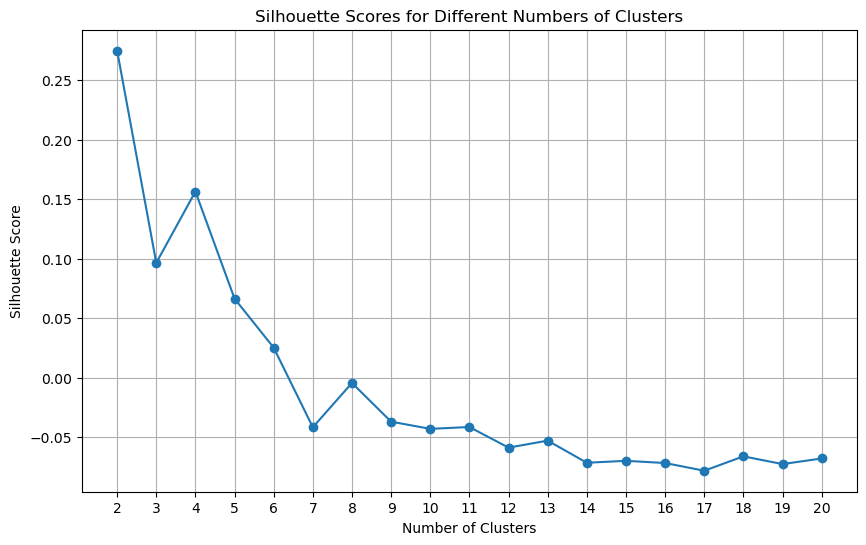

In [28]:
os.environ["OMP_NUM_THREADS"] = "7"  # Adjust the number of threads if needed

# Define the range for the number of clusters
cluster_range = range(2, 21)  # Start with 2 clusters (minimum valid for silhouette score)

# Initialize a list to store results
results = []

# Loop through each number of clusters
for n_clusters in cluster_range:
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = gmm.fit_predict(X_scaled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    
    # Append the results
    results.append({'Number of Clusters': n_clusters, 'Silhouette Score': silhouette_avg})

    print(f"Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table
display(results_df)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_df['Number of Clusters'], results_df['Silhouette Score'], marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()